# Kolmogorov-Arnold-Networks

The goal here is to predict the next value of a time series using the previous observations, and to compare two different neural architectures:
a classical multilayer perceptron, and a Kolmogorov–Arnold Network.
KANs are interesting because, instead of mixing all inputs immediately, they first learn one function per input variable, and only combine them at the end. This makes them more interpretable.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## Time Series Dataset Generation

We start by creating a synthetic dataset.
It’s simply a sine wave over time, to which we add some Gaussian noise. 
This gives us a smooth underlying signal, but with enough randomness to make prediction non-trivial.
We plot it to visually check what we’re working with — a noisy but clearly structured time series.

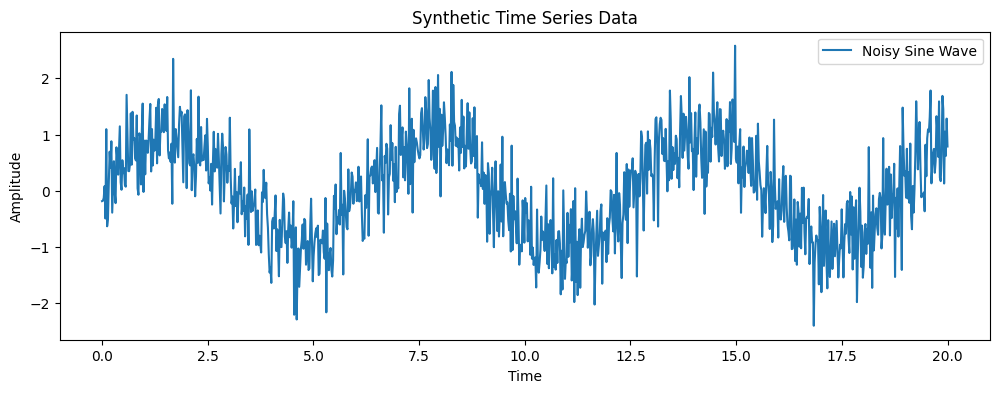

In [2]:
# Generate time points
t = np.linspace(0, 20, 1000)
# Generate random values for the time series
data = np.sin(t) + 0.5 * np.random.randn(1000)

# Plot the generated data
plt.figure(figsize=(12,4))
plt.plot(t, data, label = 'Noisy Sine Wave')
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Data Preparation for Modelling
To turn this into a supervised learning task, we use a sliding window approach.
We use a window size (`n_steps`) of 4, meaning each input sample contains the four previous observations.
Concretely, each training example consists of the last four observed values, and the target is the value that comes immediately after.
So the model learns a mapping from the past four time steps to the next one.
Once the input–output pairs are created, we convert everything to PyTorch tensors, split the data into training and test sets, and wrap them into DataLoaders for efficient mini-batch training

In [3]:
# Define the window size.
n_steps = 4

# Create input-output pairs
X = []
Y = []
for i in range(len(data) - n_steps):
    X.append(data[i:i+n_steps])
    Y.append(data[i+n_steps])

X = np.array(X)
Y = np.array(Y)

# Convert to PyTorch Tensors
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

# Split into training and test sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

# Create DataLoaders
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Implement the MLP

Our first model is a standard multilayer perceptron.
It takes the four previous time steps as input, passes them through a couple of fully connected layers with ReLU activations, and outputs a single scalar prediction.
This serves as a baseline: it’s expressive, but completely mixes all inputs together from the first layer.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.model(x)

## Implement the KAN

The second model is the Kolmogorov–Arnold Network.

Here, instead of immediately combining the four inputs, we treat each input separately at first.
Each time step is passed through its own small neural network — what we call a univariate function.
So we learn one nonlinear transformation per input feature.
Once all these univariate transformations are computed, we concatenate their outputs and feed them into a final network that combines them to produce the prediction.

In [5]:
class KAN(nn.Module):
    def __init__(self, input_size):
        super(KAN, self).__init__()
        #Univariate function layers
        self.univariate_function_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
            )
            for _ in range(input_size)
        ])

        #Combining function layers
        self.combine_funcs = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        # Apply univariate function layers
        univariate_outputs = []
        for i in range(x.size(1)):
            xi = x[:, i].unsqueeze(1)
            univariate_output = self.univariate_function_layers[i](xi)
            univariate_outputs.append(univariate_output)
        # Concatenate univariate outputs
        concatenated_outputs = torch.cat(univariate_outputs, dim=1)
        # Apply combining function
        output = self.combine_funcs(concatenated_outputs)
        return output

## Training Function

Both models are trained using the same training loop.
We use mean squared error as the loss function and Adam as the optimizer, a gradient descent algorithm. 
We use early stopping to prevent overfitting by stopping training when the validation loss stops improving for a certain number of epochs. 
We also print the training and test losses at each epoch to monitor convergence.
At each epoch, we first train on the training set, then evaluate the model on the test set to track generalization performance.
We store and later plot both training and test losses so we can visually compare convergence and overfitting behavior.

In [6]:
def train(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), Y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
    #Evaluate on test data
        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for X_batch, Y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), Y_batch)
                epoch_test_loss += loss.item() * X_batch.size(0)
                
        epoch_test_loss /= len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')
    return train_losses, test_losses

## Train the MLP model

In [7]:
input_size = n_steps
mlp_model = MLP(input_size)
mlp_train_losses, mlp_test_losses = train(mlp_model, train_loader, test_loader, num_epochs=10, learning_rate=0.001)

Epoch [10/10], Train Loss: 0.2914, Test Loss: 0.3419


## Train the KAN model

In [8]:
kan_model = KAN(input_size)
kan_train_losses, kan_test_losses = train(kan_model, train_loader, test_loader, num_epochs=20, learning_rate=0.001)

Epoch [10/20], Train Loss: 0.3044, Test Loss: 0.3458


Epoch [20/20], Train Loss: 0.2946, Test Loss: 0.3434


## Visualize the Training and Test losses

After training, we visualize the loss curves for both models.
This allows us to see how quickly each model learns and whether one of them generalizes better than the other.
In practice, both models learn the signal, but their learning dynamics can differ.

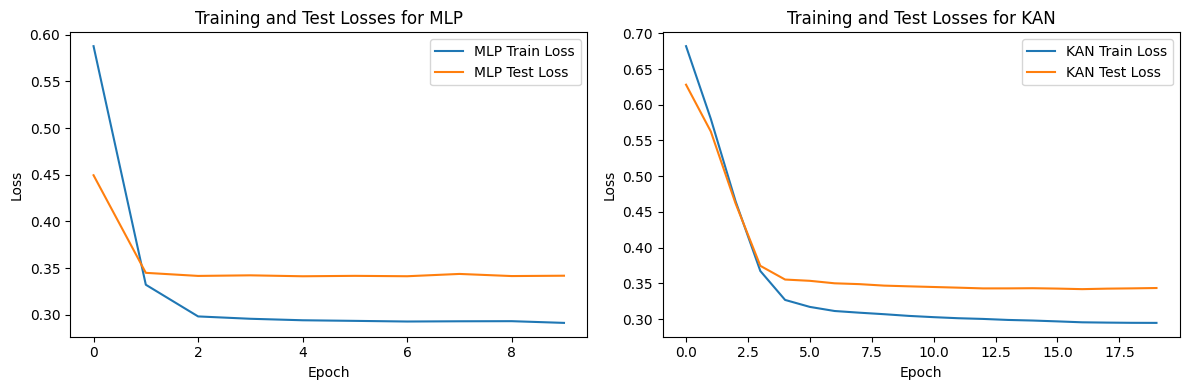

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(mlp_train_losses, label='MLP Train Loss')
plt.plot(mlp_test_losses, label='MLP Test Loss')
plt.title('Training and Test Losses for MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(kan_train_losses, label='KAN Train Loss')
plt.plot(kan_test_losses, label='KAN Test Loss')
plt.title('Training and Test Losses for KAN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate and Visualize Predictions

We then compare the models’ predictions on the test set against the true values.
This gives an intuitive, visual sense of how well each model tracks the underlying signal.
Again, the MLP and the KAN may produce similar accuracy, but they arrive there in very different ways.

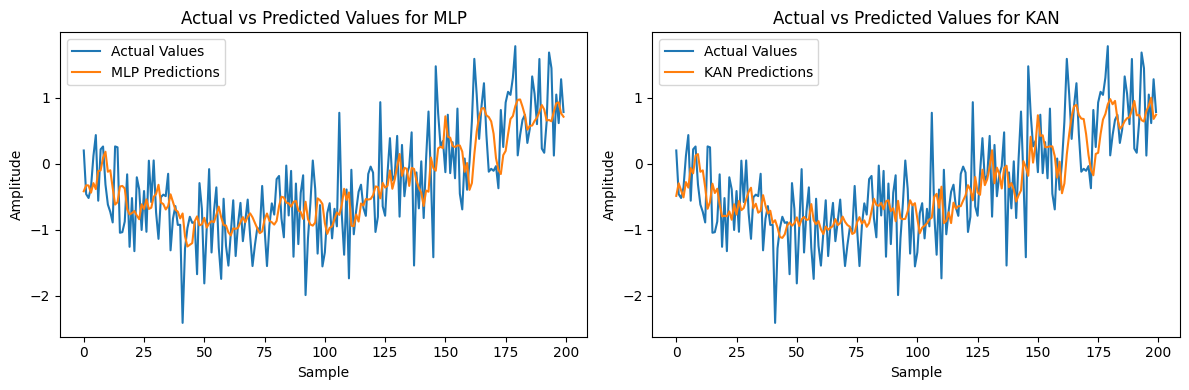

In [10]:
def evaluate_model(model, X_data):
    model.eval()
    with torch.no_grad():
        predictions = model(X_data).squeeze().numpy()
    return predictions

#Get predictions on test data
mlp_predictions = evaluate_model(mlp_model, X_test)
kan_predictions = evaluate_model(kan_model, X_test)

# Actual values
y_actual = Y_test.numpy()

#plot the predictions
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(y_actual, label='Actual Values')
plt.plot(mlp_predictions, label='MLP Predictions')
plt.title('Actual vs Predicted Values for MLP')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_actual, label='Actual Values')
plt.plot(kan_predictions, label='KAN Predictions')
plt.title('Actual vs Predicted Values for KAN')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

## Calculate Error Metrics

To make the comparison more rigorous, we compute standard regression metrics: mean squared error and mean absolute error.
This lets us compare performance numerically, beyond just visual inspection.

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_error_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{model_name} -- MSE: {mse:.4f}, MAE: {mae:.4f}')

print_error_metrics(y_actual, mlp_predictions, 'MLP')
print_error_metrics(y_actual, kan_predictions, 'KAN')

MLP -- MSE: 0.3419, MAE: 0.4721
KAN -- MSE: 0.3434, MAE: 0.4752


##Extract & plot univariate functions

In [12]:
def plot_univariate_functions(kan_model, X_data, feature_names=None):
    num_features = X_data.size(1)
    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(num_features)]

    plt.figure(figsize=(12, 8))

    for i in range(num_features):
        #Get the specific univariate function for the feature
        univariate_function = kan_model.univariate_function_layers[i]

        #generate a range of input values
        xi_min = X_data[:, i].min().item()
        xi_max = X_data[:, i].max().item()
        xi_range = torch.linspace(xi_min, xi_max, 100).unsqueeze(1)

        # pass through the univariate function and take the first output
        with torch.no_grad():
            yi = univariate_function(xi_range)[:, 0].squeeze().numpy() #Only take the first output

        #Plot the function
        plt.subplot((num_features + 1) // 2, 2, i + 1)
        plt.plot(xi_range.numpy(), yi, label=f'Feature {i+1}')
        plt.title(f'Univariate Function for {feature_names[i]}')
        plt.xlabel('Input Value')
        plt.ylabel('Output Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Plot the univariate functions

One of the main advantages of the KAN is interpretability.
Because each input has its own learned function, we can extract and plot those functions directly.
For each time step, we vary that input over its observed range and visualize how the corresponding univariate network transforms it.
This gives us insight into how each past observation contributes to the final prediction — something that’s very difficult to do with a standard MLP.

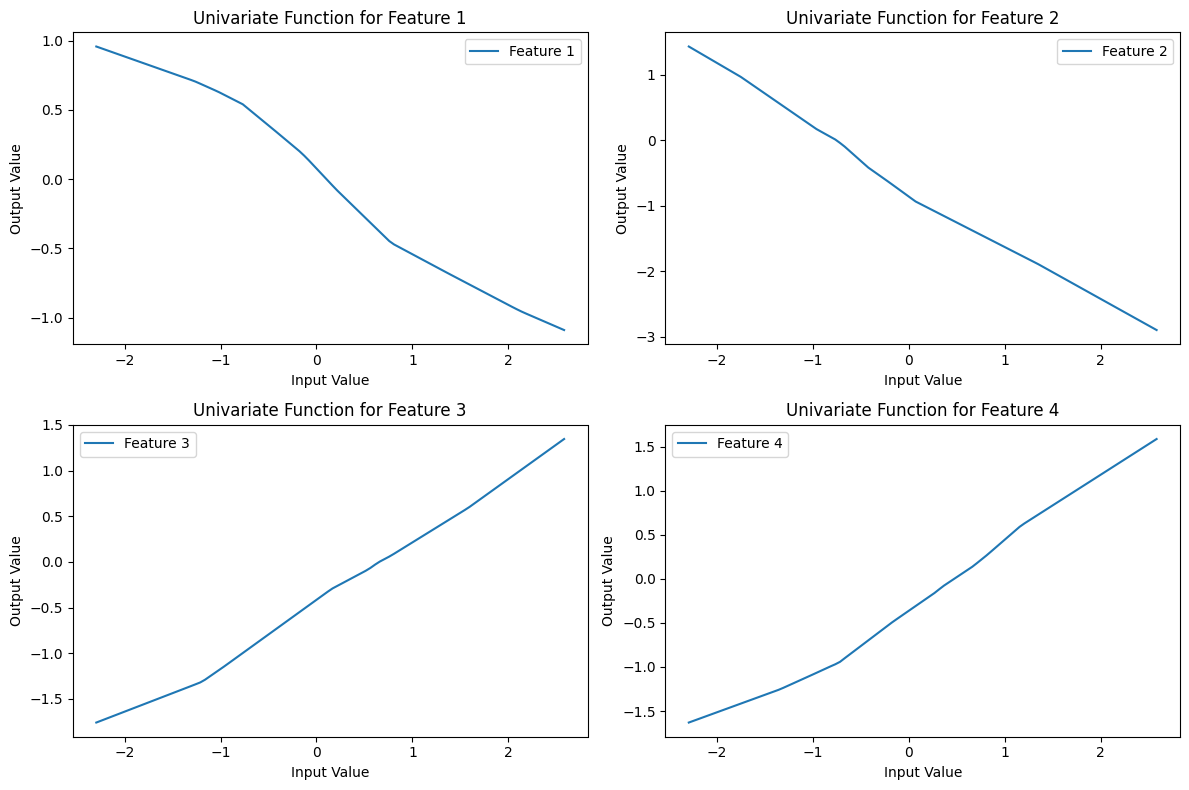

In [13]:
plot_univariate_functions(kan_model, X_train)

These four subplots show a negative slope : The higher the output, the lower the input. The higher the input value, the lower the output value. This is to be expected in a sine wave. The KAN allows us to clearly a global trend. 